# Context

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

# Data Definitions

Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	    Ticket      class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	        Sex	
Age	        Age in years	
sibsp	    # of siblings / spouses aboard the Titanic	
parch	    # of parents / children aboard the Titanic	
ticket	    Ticket number	
fare	    Passenger fare	
cabin	    Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

**Based on the data definitions, we can imagine that some of the categories may nee dto be cleaned or future features created. Lets bring in the data**

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [166]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [167]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Findings**

* All values are filled in except for age, cabin and embark
* Cabin has low responses, so may want to drop column
* Name may be text mined to get more information about marriage status, class, etc
* Ticket could be potentially text mined, need to seee if all of the values are unique or not
* Survived is our target variable
* Embarked data could have the variables renamed to be easier to understand


In [169]:
# lets see what the unique values are for each feature

for column in df.columns:
    print(column)
    print(df[column].value_counts())
    print("*"*30)

PassengerId
1      1
599    1
588    1
589    1
590    1
      ..
301    1
302    1
303    1
304    1
891    1
Name: PassengerId, Length: 891, dtype: int64
******************************
Survived
0    549
1    342
Name: Survived, dtype: int64
******************************
Pclass
3    491
1    216
2    184
Name: Pclass, dtype: int64
******************************
Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64
******************************
Sex
male      577
female    314
Name: Sex, dtype: int6

**Findings**

* PassengerId, name, ticket, and cabin are all, or mostly unique values. PassengerId, cabin, and ticket can be dropped, while name we will try to mine further



In [170]:
df.drop(['PassengerId', 'Ticket', 'Cabin'], axis= 1, inplace=True)
df_test.drop(['PassengerId', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [171]:
#check if values have been dropped
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [172]:
## tranforming Embarked codes to real words

embark_codes = {
    'C':  'Cherbourg',
    'Q': 'Queenstown', 
    'S' : 'Southampton'
}


In [173]:
df['Embarked'].replace(embark_codes, inplace=True)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,Southampton
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,Cherbourg
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,Southampton
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,Southampton
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,Southampton
...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,Southampton
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,Southampton
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.4500,Southampton
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,Cherbourg


In [174]:
df_test['Embarked'].replace(embark_codes, inplace=True)
df_test

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Queenstown
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,Southampton
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Queenstown
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,Southampton
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,Southampton
...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",male,NaN,0,0,8.0500,Southampton
414,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,108.9000,Cherbourg
415,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,7.2500,Southampton
416,3,"Ware, Mr. Frederick",male,NaN,0,0,8.0500,Southampton


In [175]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Findings**

* SipSp, Parch, and fare have outliers that may need to be dealt with

# Exploratory Data Analysis

Lets dive into the data in more detail

In [176]:
# Seperating data into X and y

X = df.copy()
X = X.drop('Survived', axis = 1)

y = df['Survived']

In [177]:
X

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,Southampton
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,Cherbourg
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,Southampton
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,Southampton
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,Southampton
...,...,...,...,...,...,...,...,...
886,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,Southampton
887,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,Southampton
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.4500,Southampton
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,Cherbourg


In [178]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [179]:
# seperate cat and num columns

num_features = []

cat_features = []

In [180]:
for column in X.columns:

    if X[column].dtype == 'object':
        cat_features.append(column)
    else:
        num_features.append(column)

In [181]:
print(num_features)
print(cat_features)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
['Name', 'Sex', 'Embarked']


## Univariate Categorical Analysis 

Lets look at how the catgorical data is distributed

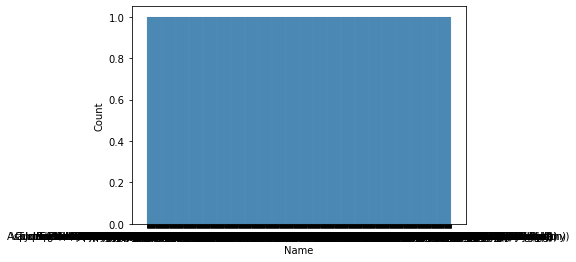

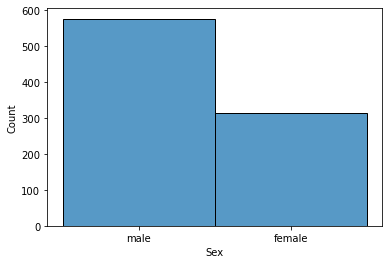

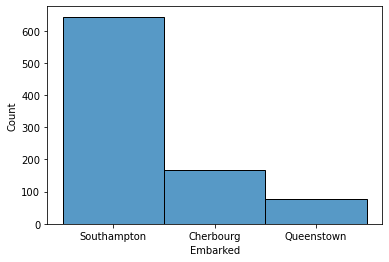

In [182]:
for cat in cat_features:
    sns.histplot(data=X[cat])
    plt.show()

**Findings**

* Name data will need to be cleaned up, their title (mr, mrs, rev, etc) seems to be the 3rd word in their name, so we can pull from that

* The passengers were mostly male, from southampton

In [183]:
X['title'] = X['Name'].str.split(expand=True)[1]
df_test['title'] = df_test['Name'].str.split(expand=True)[1]

In [184]:
X

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,Southampton,Mr.
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,Cherbourg,Mrs.
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,Southampton,Miss.
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,Southampton,Mrs.
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,Southampton,Mr.
...,...,...,...,...,...,...,...,...,...
886,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,Southampton,Rev.
887,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,Southampton,Miss.
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.4500,Southampton,Miss.
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,Cherbourg,Mr.


In [185]:
X['title'].value_counts()

Mr.             502
Miss.           179
Mrs.            121
Master.          40
Dr.               7
Rev.              6
y                 4
Planke,           3
Impe,             3
Gordon,           2
Col.              2
Mlle.             2
Major.            2
Melkebeke,        1
Jonkheer.         1
Shawah,           1
the               1
Velde,            1
Capt.             1
Messemaeker,      1
Carlo,            1
Ms.               1
Mme.              1
Steen,            1
Mulder,           1
Pelsmaeker,       1
Walle,            1
der               1
Billiard,         1
Don.              1
Cruyssen,         1
Name: title, dtype: int64

**Findings**

* 4 titles come up as most common, mr, miss, mrs, and master

* Based on research of titles in the early 1910s, Mr and Mrs denote adults, while Miss and Master denote children (miss sometimes an unmarried adult). May want to look into creating a feature for is child or not

* There are some honorable titles like dr and rev that may help with the modeling

In [186]:
X['is_child'] = X['title'].apply(lambda x: 1 if x in ('Master.', 'Miss.') else 0 )

df_test['is_child'] = df_test['title'].apply(lambda x: 1 if x in ('Master.', 'Miss.') else 0 )

In [187]:
X

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,title,is_child
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,Southampton,Mr.,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,Cherbourg,Mrs.,0
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,Southampton,Miss.,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,Southampton,Mrs.,0
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,Southampton,Mr.,0
...,...,...,...,...,...,...,...,...,...,...
886,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,Southampton,Rev.,0
887,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,Southampton,Miss.,1
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.4500,Southampton,Miss.,1
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,Cherbourg,Mr.,0


In [188]:
df_test

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,title,is_child
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Queenstown,Mr.,0
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,Southampton,Mrs.,0
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Queenstown,Mr.,0
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,Southampton,Mr.,0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,Southampton,Mrs.,0
...,...,...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",male,NaN,0,0,8.0500,Southampton,Mr.,0
414,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,108.9000,Cherbourg,y,0
415,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,7.2500,Southampton,Mr.,0
416,3,"Ware, Mr. Frederick",male,NaN,0,0,8.0500,Southampton,Mr.,0


**Adding the is_child feature may make up for some of the missing ages. I can now drop title and name** 

In [189]:
X = X.drop(['Name', 'title'], axis = 1)
df_test = df_test.drop(['Name', 'title'], axis = 1)

In [190]:
#create feature for group size

X['group_size'] = X['SibSp'] + X['Parch'] + 1

df_test['group_size'] = df_test['SibSp'] + df['Parch'] + 1

In [192]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,is_child,group_size
0,3,male,22.0,1,0,7.2500,Southampton,0,2
1,1,female,38.0,1,0,71.2833,Cherbourg,0,2
2,3,female,26.0,0,0,7.9250,Southampton,1,1
3,1,female,35.0,1,0,53.1000,Southampton,0,2
4,3,male,35.0,0,0,8.0500,Southampton,0,1
...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,Southampton,0,1
887,1,female,19.0,0,0,30.0000,Southampton,1,1
888,3,female,NaN,1,2,23.4500,Southampton,1,4
889,1,male,26.0,0,0,30.0000,Cherbourg,0,1


**Given the changes made to the features, lets grab the numeric and cat features again, and look at the data**

In [196]:
num_features = []
cat_features = []

In [197]:
for col in X.columns:
    if X[col].dtypes == 'object':
        cat_features.append(col)
    else:
        num_features.append(col)

In [198]:
print(num_features)
print(cat_features)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'is_child', 'group_size']
['Sex', 'Embarked']


## Categorical Features - Univariate exploration pt 2


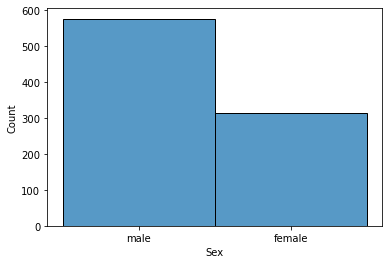

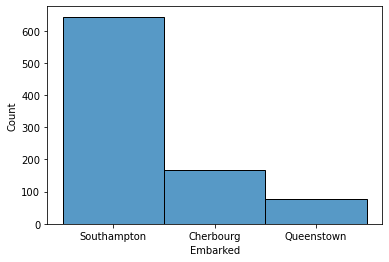

In [199]:
for cat in cat_features:
    sns.histplot(data=X[cat])
    plt.show()

**Findings**

 Most of the passengers are male, and most come from Southampton

## Categorical Features, bivariate analysis

Let's look at the categorical features vs the target

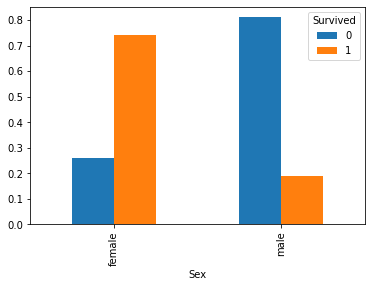

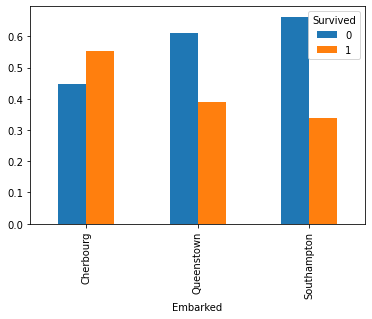

In [200]:
for cat in cat_features:
    pd.crosstab(X[cat], y, normalize = 'index' ).plot(kind='bar')
    plt.show()

**Findings**
* Almost 80% of men did not survive, while almost 80% of women did. Gender is one of the biggest differentiators at this moment
* Southampton, followed by Queestown have the highest rate of non survival. Cherbourg is the only location with a positiove survival rate

## Numerical Features - Univariate analysis

Now lets look at how the numerical features are distributed

In [201]:
def hist_and_box(feature):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))
    sns.histplot(feature, ax=ax1)
    sns.boxplot(feature, ax = ax2)           
               
    
    

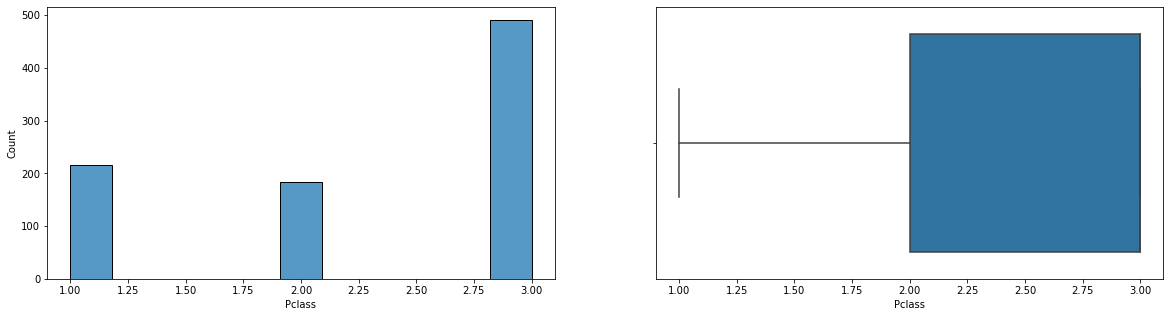

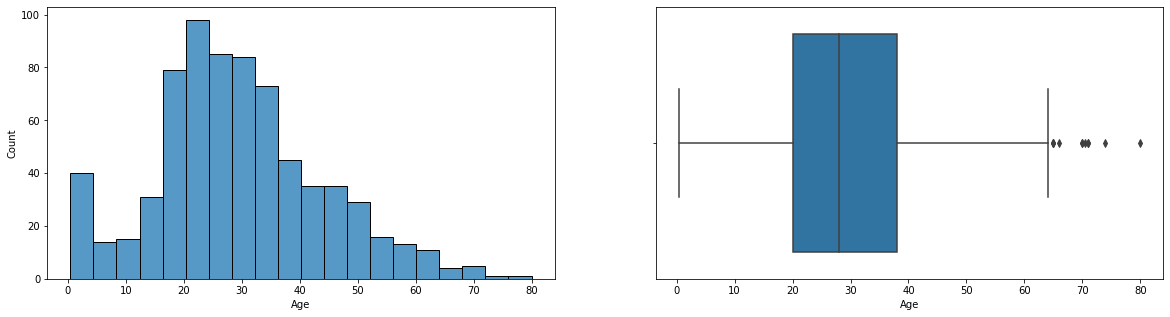

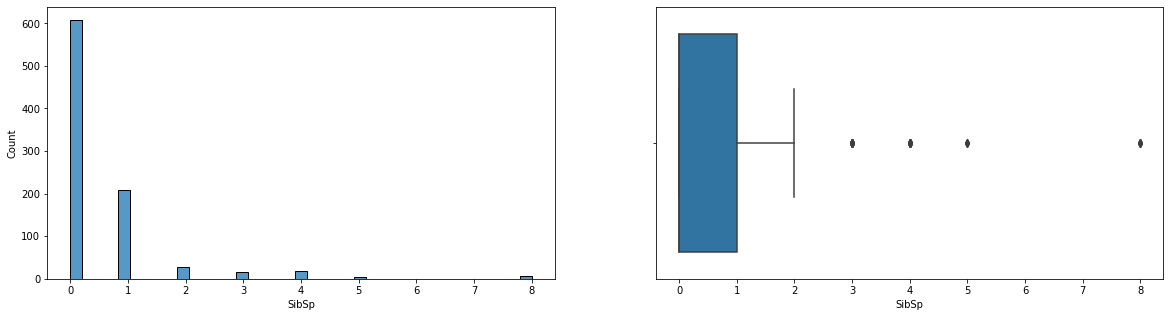

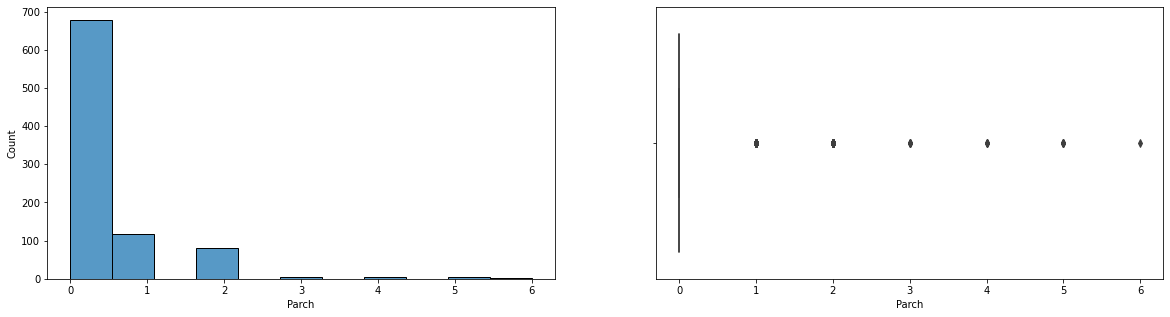

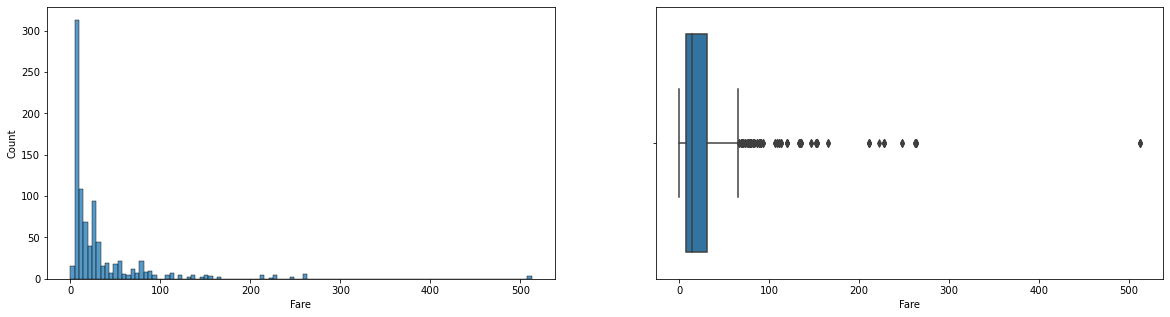

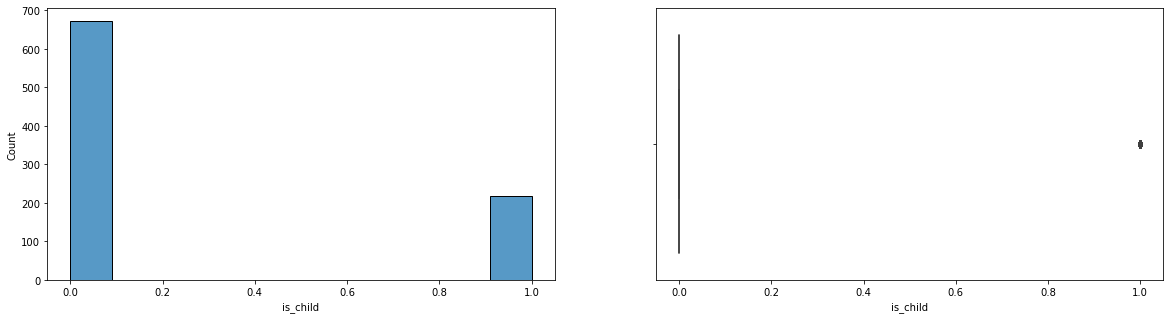

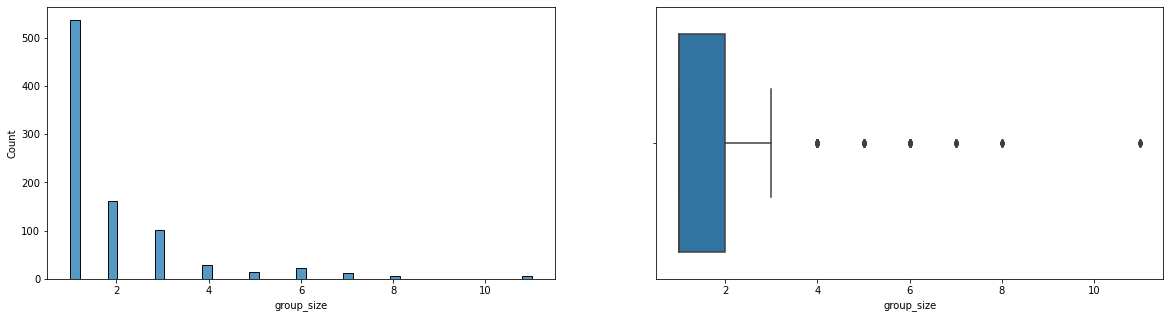

In [202]:
for feature in num_features:
    hist_and_box(X[feature])

**Findings**

* Majority of passengers were in 3rd class

* age is almost noirmally distributed, except there are a lot of children under 5, and a few outliers over their mid 60s

* most passengers have one or less sibling/spouses with them

* Most passengers have 0 parents or children with them

* Most passengers paid under 90 dollars for fare, with a large amount of outliers. May want to cap outliers or normalize this

* The majority of passengers fall into the 'is child' category, maybe this is more accurately "is single'

* the moajority of groups were 3 or less peoeple